<h1><center><font size="6">MIMIC Dataset EDA and Prediction of Hospital LOS</font></center></h1>

# <a id='2'>Prepare the data analysis</a>  

## Load packages

In [1]:
import gc
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,train_test_split
#import lightgbm as lgb
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix

## Load data

In [2]:

mimic_df = pd.read_csv('mimic3d.csv')

In [3]:
mimic_df.shape

(58976, 28)

In [4]:
mimic_df.head()

,hadm_id,gender,age,LOSdays,admit_type,admit_location,AdmitDiagnosis,insurance,religion,marital_status,...,NumMicroLabs,NumNotes,NumOutput,NumRx,NumProcEvents,NumTransfers,NumChartEvents,ExpiredHospital,TotalNumInteract,LOSgroupNum
0,100001,F,35,6.17,EMERGENCY,CLINIC REFERRAL/PREMATURE,DIABETIC KETOACIDOSIS,Private,PROTESTANT QUAKER,DIVORCED,...,0.65,0.05,5.19,14.91,1.13,0.65,398.70,0,493.89,1
1,100003,M,59,4.04,EMERGENCY,EMERGENCY ROOM ADMIT,UPPER GI BLEED,Private,NOT SPECIFIED,SINGLE,...,1.24,1.59,5.45,7.18,0.99,1.24,373.02,0,465.71,1
2,100006,F,48,12.04,EMERGENCY,EMERGENCY ROOM ADMIT,COPD FLARE,Private,NOT SPECIFIED,SINGLE,...,0.33,0.15,4.15,6.23,0.00,0.33,286.21,0,344.00,3
3,100007,F,73,7.29,EMERGENCY,EMERGENCY ROOM ADMIT,BOWEL OBSTRUCTION,Private,JEWISH,MARRIED,...,0.69,0.17,9.05,11.52,0.00,0.96,526.06,0,603.05,1
4,100009,M,60,4.88,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,CORONARY ARTERY DISEASE,Private,CATHOLIC,MARRIED,...,0.61,0.34,16.19,25.00,2.87,2.05,554.92,0,679.84,1


# <a id='3'>Data exploration</a>  


In [17]:
def plot_features_distribution(features, title,isLog=False):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        if(isLog):
            sns.distplot(np.log1p(mimic_df[feature]),kde=True,hist=False, bins=120, label=feature)
        else:
            sns.distplot(mimic_df[feature],kde=True,hist=False, bins=120, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.savefig('VariousProcAndEvents.pdf')
    plt.show()

In [6]:
def plot_count(feature, title,size=1,df=mimic_df):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:30], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()   

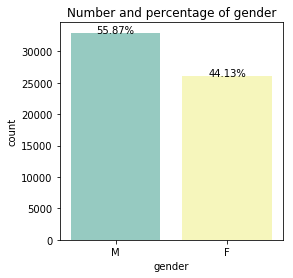

In [7]:
plot_count('gender','gender')

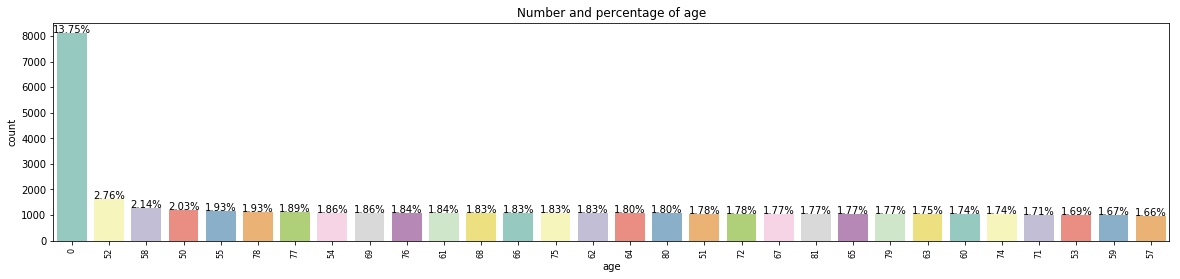

In [8]:
plot_count('age','age',5)

C:\Users\faisal.maqbool\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


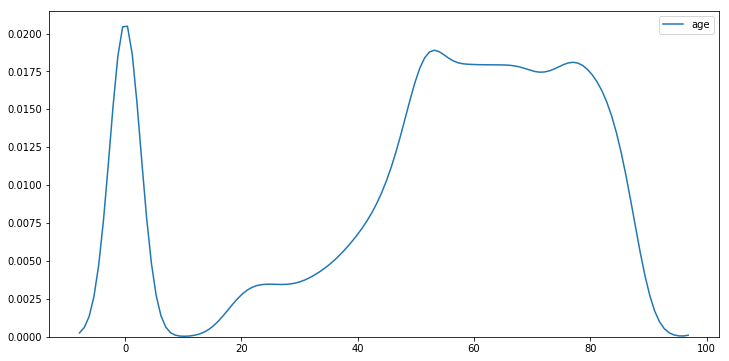

In [9]:
plot_features_distribution(['age'],'Patient age distribution')

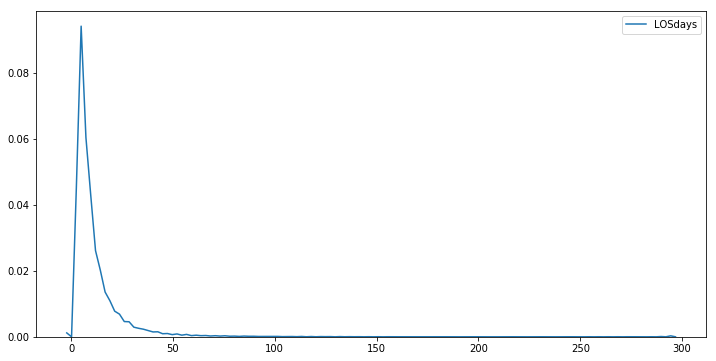

In [10]:
plot_features_distribution(['LOSdays'],'Patient length of stay (days) distribution')

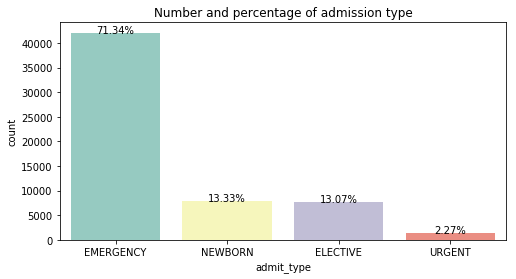

In [11]:
plot_count('admit_type','admission type',2)

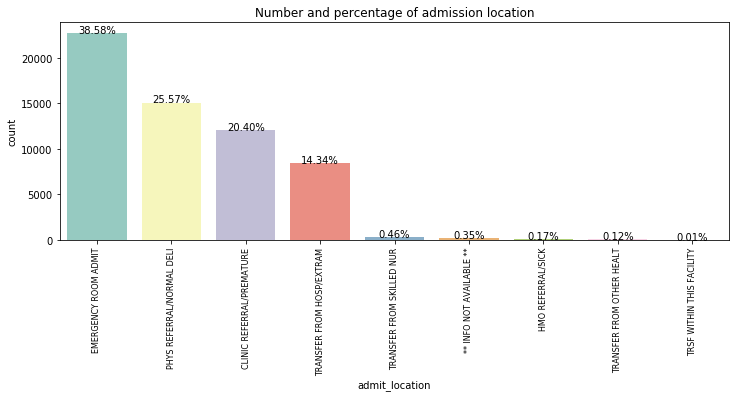

In [12]:
plot_count('admit_location','admission location',3)

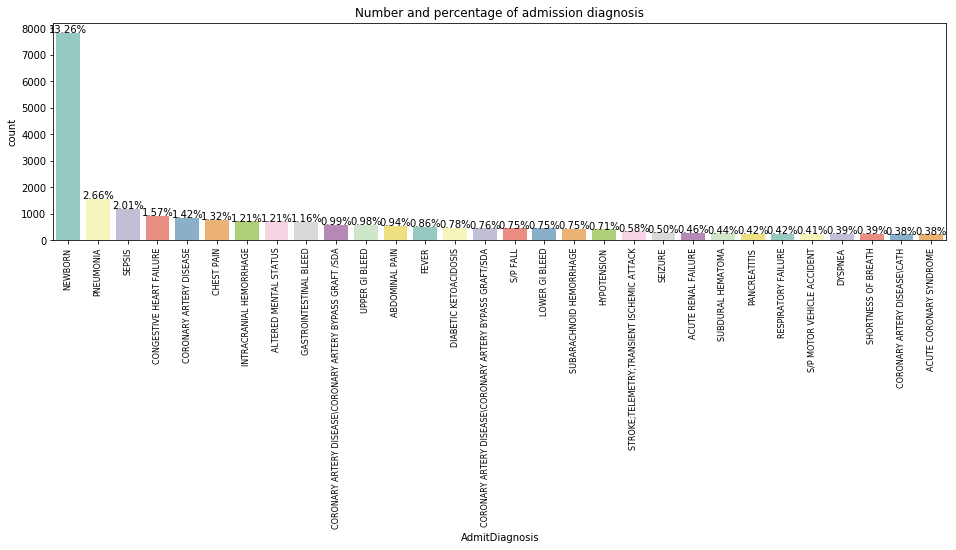

In [13]:
plot_count('AdmitDiagnosis','admission diagnosis',4)

In [14]:
mimic_df.AdmitDiagnosis.nunique()

15691

There is a total of 15691 admission diagnosis. Most of the patients are actually newborn (13.26%). Besides newborn, majority of the admitted patients are diagnosed with pneumonia, sepsis, congestive heart failure, coronary artery disease and chest pain.

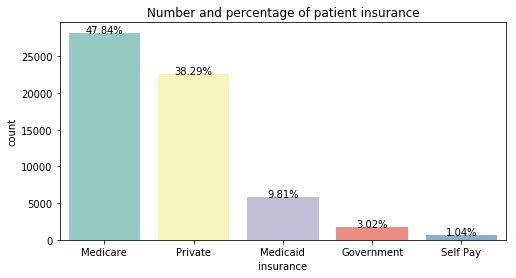

In [13]:
plot_count('insurance','patient insurance',2)

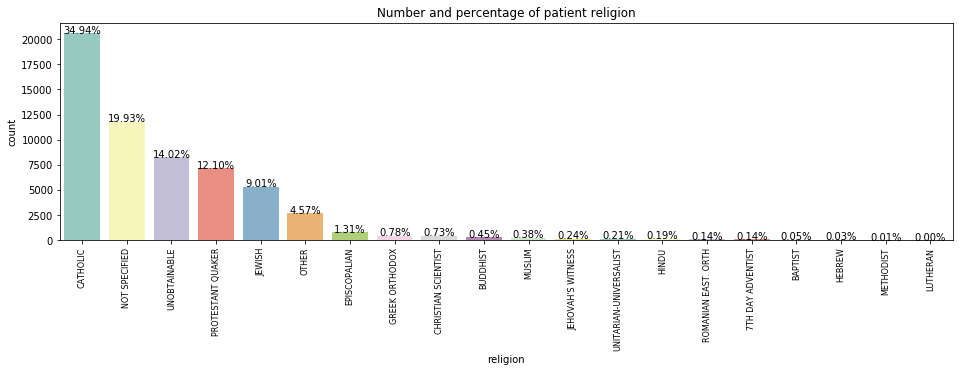

In [16]:
plot_count('religion','patient religion',4)

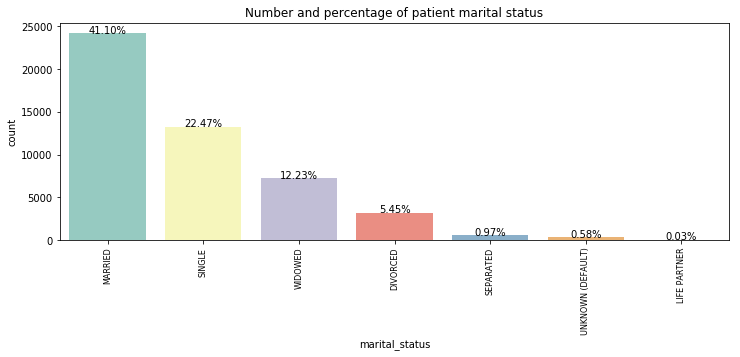

In [14]:
plot_count('marital_status','patient marital status',3)

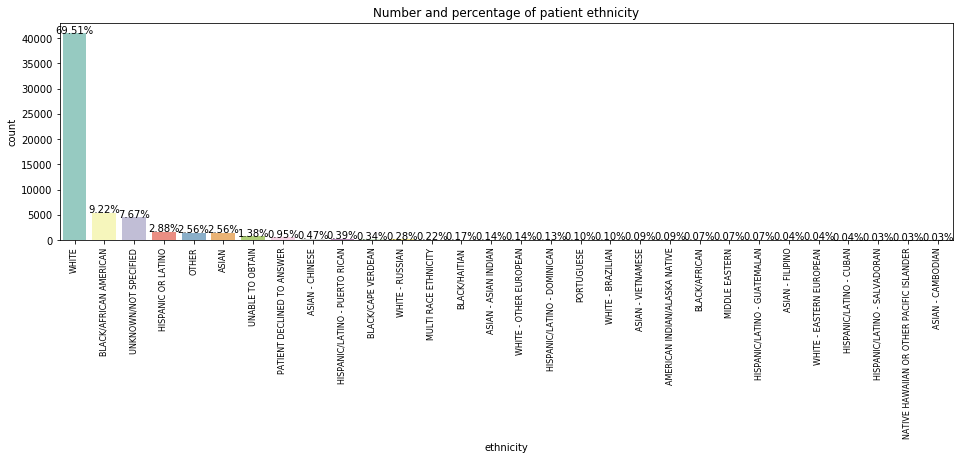

In [19]:
plot_count('ethnicity','patient ethnicity',4)

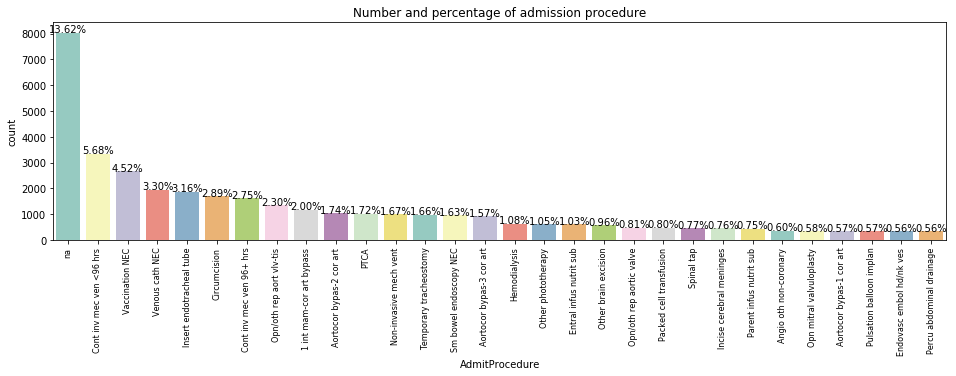

In [20]:
plot_count('AdmitProcedure', 'admission procedure', 4)

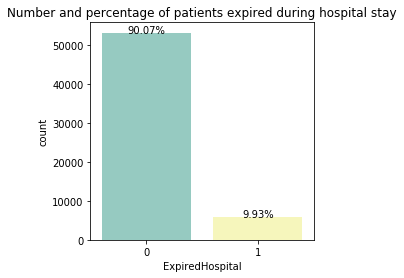

In [21]:
plot_count('ExpiredHospital', 'patients expired during hospital stay')

Let's check most prevalent diagnosis and ages of patients which expired in hospital.  

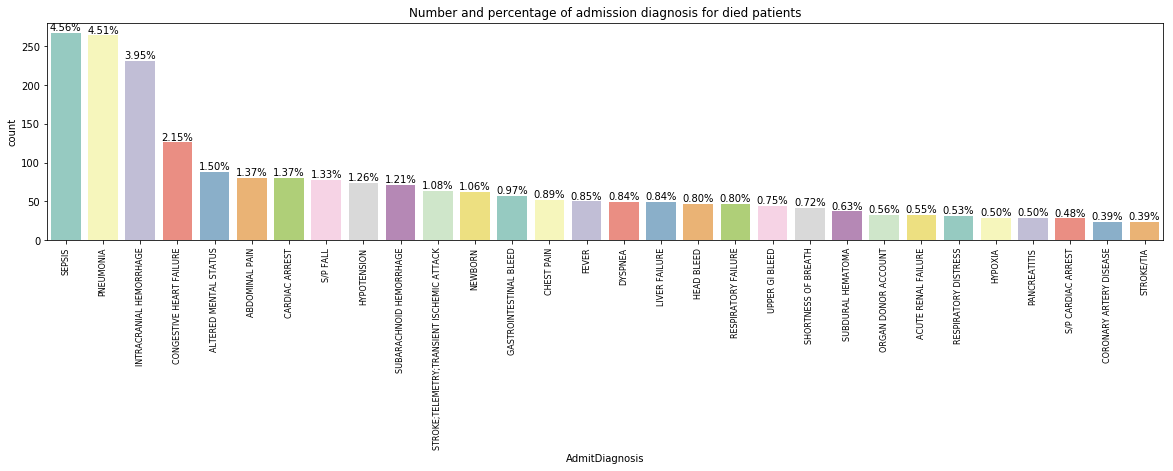

In [22]:
plot_count('AdmitDiagnosis','admission diagnosis for died patients',5,mimic_df[mimic_df.ExpiredHospital==1])

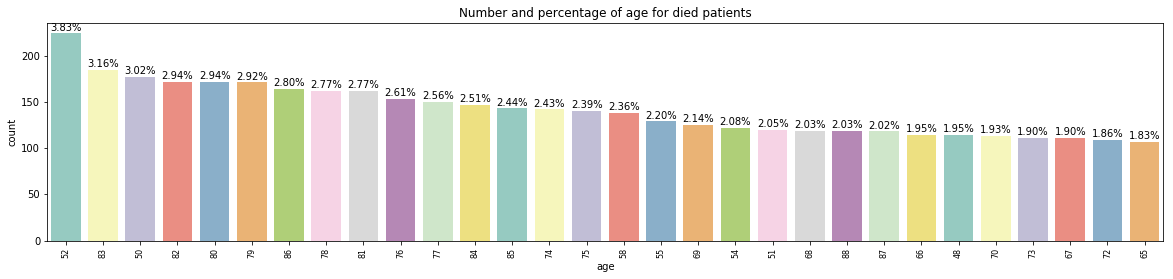

In [23]:
plot_count('age','age for died patients',5,mimic_df[mimic_df.ExpiredHospital==1])

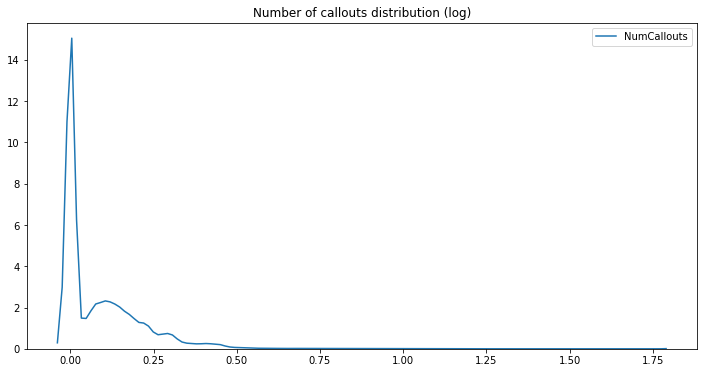

In [24]:
plot_features_distribution(['NumCallouts'], 'Number of callouts distribution (log)',True)

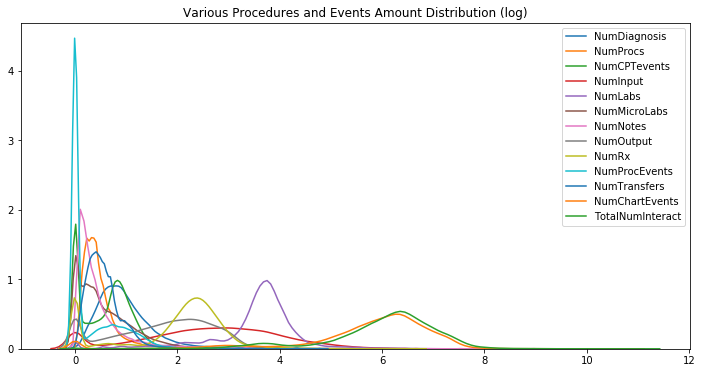

In [20]:
features = ['NumDiagnosis','NumProcs','NumCPTevents','NumInput','NumLabs','NumMicroLabs','NumNotes',
'NumOutput','NumRx','NumProcEvents','NumTransfers','NumChartEvents','TotalNumInteract']
plot_features_distribution(features, 'Various Procedures and Events Amount Distribution (log)',True)

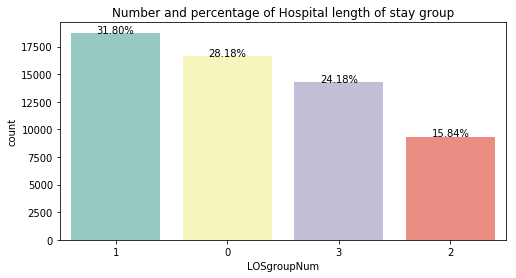

In [26]:
plot_count('LOSgroupNum', 'Hospital length of stay group',2)

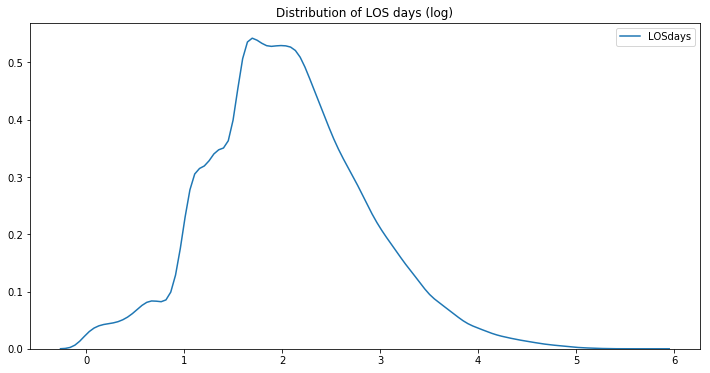

In [27]:
plot_features_distribution(['LOSdays'], 'Distribution of LOS days (log)',True)

# <a id='4'>Predict Hospital LOS</a> 

Accurate prediction of Hospital length of stay is important for the hospital activity management, for optimal forecast of required capacity  for number of beds but also for each procedure specific to a certain group age or diagnosis.  


We encode the categorical features using LabelEncoder.

In [28]:
categorical_features = ['gender', 'admit_type', 'admit_location', 'AdmitDiagnosis', 'insurance', 'religion',
              'marital_status', 'ethnicity', 'AdmitProcedure']

In [29]:
def encrypt_single_column(data,column):
    le = preprocessing.LabelEncoder()
    le.fit(data.astype(str))
    #le_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))
    return le.transform(data.astype(str))


def encrypt_columns_collection(data, columns_to_encrypt):
    for column in columns_to_encrypt:
        data[column] = encrypt_single_column(data[column],column)
    return data

In [30]:
mimic_df = encrypt_columns_collection(mimic_df, categorical_features)

Let's split  the dataset in train and test.

In [31]:
train_df, test_df = train_test_split(mimic_df, test_size=0.2, random_state=42, shuffle=True )

We use as predictors only the informations available at the admission time. We are not including information that might be highly correlated with the length of stay (like number of specific events or procedures during the hospital stay). 

In [32]:
predictors = ['gender', 'age', 'admit_type', 'admit_location', 'AdmitDiagnosis', 'insurance', 'religion',
              'marital_status', 'ethnicity', 'AdmitProcedure']

In [39]:
train_X = train_df[predictors]
test_X = test_df[predictors]
train_y = train_df['LOSdays']
test_y = test_df['LOSdays']

In [42]:
warnings.filterwarnings("ignore")

In [43]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = train_X.columns.values
params = {'num_leaves': 65, 'min_data_in_leaf': 12, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.81,"bagging_freq": 1, "bagging_fraction": 0.81, "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbose": -1, "nthread": -1,  "random_state": 44000}
oof = np.zeros(len(train_X))
predictions = np.zeros(len(test_X))

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)

    X_tr, X_val = train_X.iloc[trn_idx], train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 20000)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    categorical_feature=categorical_features,
                    verbose=500, 
                    early_stopping_rounds=100)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #predictions
    predictions += model.predict(test_X, num_iteration=model.best_iteration_) / folds.n_splits
strLog = "CV score: {}".format(np.sqrt(mean_squared_error(train_y.values, oof)))
print(strLog)

fold 0
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 6.62527	valid_1's l1: 6.61508
[1000]	training's l1: 6.18062	valid_1's l1: 6.23579
[1500]	training's l1: 5.91478	valid_1's l1: 6.02642
[2000]	training's l1: 5.75056	valid_1's l1: 5.91004
[2500]	training's l1: 5.64524	valid_1's l1: 5.84584
[3000]	training's l1: 5.57399	valid_1's l1: 5.813
[3500]	training's l1: 5.52162	valid_1's l1: 5.79865
[4000]	training's l1: 5.47936	valid_1's l1: 5.79164
[4500]	training's l1: 5.44292	valid_1's l1: 5.78921
Early stopping, best iteration is:
[4442]	training's l1: 5.44665	valid_1's l1: 5.78904
fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 6.59443	valid_1's l1: 6.70319
[1000]	training's l1: 6.15224	valid_1's l1: 6.31494
[1500]	training's l1: 5.88702	valid_1's l1: 6.11078
[2000]	training's l1: 5.7231	valid_1's l1: 6.00077
[2500]	training's l1: 5.61667	valid_1's l1: 5.9393
[3000]	training's l1: 5.54357	valid_1's l1: 5.90755

Let's check now the predictions.

In [44]:
strPred = "Prediction score: {}".format(np.sqrt(mean_squared_error(test_y.values, predictions)))
print(strPred)

Prediction score: 10.101818877798511


In [45]:
results = pd.DataFrame(test_y)
results['predictions'] = predictions
results.head(10)

,LOSdays,predictions
40028,6.79,6.974125
38143,13.50,14.203448
14276,3.38,7.075496
49801,0.25,12.170375
21549,7.08,10.801265
57372,8.08,11.227309
9263,16.04,18.490559
22715,10.17,5.375297
31032,2.75,5.558810
38586,13.83,10.734491


# <a id='4'>Predict Hospital LOS group</a>  

To predict Hospital LOS group, we will use a classifier. There are 4 LOS groups (0,1,2,3).   
We define the target feature as `LOSgroupNum`.

For this model, we add to the predictors list also the number of events and specific procedures.

In [46]:
predictors = ['gender', 'age', 'admit_type', 'admit_location', 'AdmitDiagnosis', 'insurance', 'religion',
              'marital_status', 'ethnicity', 'AdmitProcedure','NumCallouts', 'NumDiagnosis','NumProcs', 
              'AdmitProcedure', 'NumCPTevents', 'NumInput','NumLabs', 'NumMicroLabs', 'NumNotes', 'NumOutput', 
              'NumRx','NumProcEvents', 'NumTransfers', 'NumChartEvents']
categorical_features = ['gender', 'admit_type', 'admit_location', 'AdmitDiagnosis', 'insurance', 'religion',
              'marital_status', 'ethnicity', 'AdmitProcedure']
train_X = train_df[predictors]
test_X = test_df[predictors]
train_y = train_df['LOSgroupNum']
test_y = test_df['LOSgroupNum']

In [47]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = train_X.columns.values
params = {'objective':'multiclass',
          'num_class': 4,
          'metric': 'multi_logloss',
          'max_depth': -1,
          'boosting': 'gbdt',
          'learning_rate': 0.01,
          'verbose': -1, 'nthread': -1,  'random_state': 42}
oof = np.zeros(len(train_X))
predictions = np.zeros([len(test_X),4])

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X,train_y.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)

    X_tr, X_val = train_X.iloc[trn_idx], train_X.iloc[val_idx]
    y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

    model = lgb.LGBMClassifier(**params, n_estimators = 5000)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='multi_logloss',
                    categorical_feature=categorical_features,
                    verbose=500, 
                    early_stopping_rounds=50)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #predictions
    predictions += model.predict_proba(test_X, num_iteration=model.best_iteration_) / folds.n_splits
print("Classification report (train)\n{}".format(classification_report(train_y.values, oof)))

fold 0
Training until validation scores don't improve for 50 rounds.
[500]	training's multi_logloss: 0.221203	valid_1's multi_logloss: 0.254773
[1000]	training's multi_logloss: 0.129157	valid_1's multi_logloss: 0.201816
[1500]	training's multi_logloss: 0.087116	valid_1's multi_logloss: 0.18656
[2000]	training's multi_logloss: 0.0617765	valid_1's multi_logloss: 0.18015
[2500]	training's multi_logloss: 0.0454654	valid_1's multi_logloss: 0.176334
[3000]	training's multi_logloss: 0.0339816	valid_1's multi_logloss: 0.173801
Early stopping, best iteration is:
[3440]	training's multi_logloss: 0.0265621	valid_1's multi_logloss: 0.172505
fold 1
Training until validation scores don't improve for 50 rounds.
[500]	training's multi_logloss: 0.21943	valid_1's multi_logloss: 0.257356
[1000]	training's multi_logloss: 0.128751	valid_1's multi_logloss: 0.206527
[1500]	training's multi_logloss: 0.0867952	valid_1's multi_logloss: 0.191508
[2000]	training's multi_logloss: 0.0618239	valid_1's multi_logloss:

In [48]:
print("Classification report (test)\n{}".format(classification_report(test_y.values, np.argmax(predictions, axis=1))))

Classification report (test)
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3343
           1       0.92      0.95      0.94      3743
           2       0.88      0.82      0.85      1924
           3       0.94      0.93      0.93      2786

   micro avg       0.93      0.93      0.93     11796
   macro avg       0.93      0.92      0.92     11796
weighted avg       0.93      0.93      0.93     11796



The classification precision is very much improved by adding to the predictors the number of various events and procedures.

In [60]:
results = pd.DataFrame(test_y)
results['predictions'] = np.argmax(predictions, axis=1)
results.head(10)

,LOSgroupNum,predictions
40028,1,1
38143,3,3
14276,0,0
49801,0,0
21549,1,1
57372,2,2
9263,3,3
22715,2,2
31032,0,0
38586,3,3
